In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from loggers import Logger

In [4]:
# Initialize logger
loggers = Logger("userEngagement.log").get_app_logger()
loggers.info("Initialized user_experience logger")

In [5]:
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')

In [6]:
df = df_org.copy()

In [7]:
overview = Overview(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   150001 non-null  int64  
 1   Unnamed: 0.1                 150001 non-null  float64
 2   Bearer Id                    150001 non-null  float64
 3   Start                        150001 non-null  object 
 4   Start ms                     150001 non-null  float64
 5   End                          150001 non-null  object 
 6   End ms                       150001 non-null  float64
 7   Dur. (ms)                    150001 non-null  float64
 8   IMSI                         150001 non-null  float64
 9   MSISDN/Number                150001 non-null  float64
 10  IMEI                         150001 non-null  float64
 11  Last Location Name           150001 non-null  object 
 12  Avg RTT DL (ms)              150001 non-null  float64
 13 

In [9]:
df.dtypes

Unnamed: 0                       int64
Unnamed: 0.1                   float64
Bearer Id                      float64
Start                           object
Start ms                       float64
End                             object
End ms                         float64
Dur. (ms)                      float64
IMSI                           float64
MSISDN/Number                  float64
IMEI                           float64
Last Location Name              object
Avg RTT DL (ms)                float64
Avg RTT UL (ms)                float64
Avg Bearer TP DL (kbps)        float64
Avg Bearer TP UL (kbps)        float64
TCP DL Retrans. Vol (Bytes)    float64
TCP UL Retrans. Vol (Bytes)    float64
HTTP DL (Bytes)                float64
HTTP UL (Bytes)                float64
Activity Duration DL (ms)      float64
Activity Duration UL (ms)      float64
Dur. (ms).1                    float64
Handset Manufacturer            object
Handset Type                    object
Social Media DL (Bytes)  

<AxesSubplot:xlabel='Avg RTT DL (ms)'>

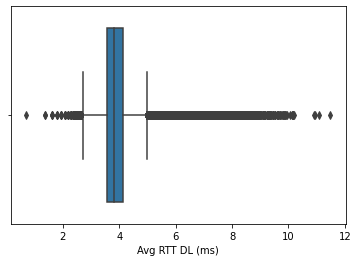

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(df['Avg RTT DL (ms)'], orient='vert')

In [13]:
user_experience = df[[
    "MSISDN/Number",
    "Avg RTT DL (ms)",
    "Avg RTT UL (ms)",
    "Avg Bearer TP DL (kbps)",
    "Avg Bearer TP UL (kbps)",
    "TCP UL Retrans. Vol (Bytes)",
    "TCP DL Retrans. Vol (Bytes)",
    "Handset Type"]]

user_experience['avg_rtt_total'] = user_experience['Avg RTT DL (ms)'] + user_experience['Avg RTT UL (ms)']
user_experience['avg_bearer_tp_total'] = user_experience['Avg Bearer TP DL (kbps)'] + user_experience['Avg Bearer TP UL (kbps)']
user_experience['avg_tcp_retrans_total'] = user_experience['TCP DL Retrans. Vol (Bytes)'] + user_experience['TCP UL Retrans. Vol (Bytes)']



In [14]:
user_experience.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP UL Retrans. Vol (Bytes),TCP DL Retrans. Vol (Bytes),Handset Type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,24.239723,3.737670,1.609438,3.135494,3.784190,9.94987,13.251161,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,23.201031
1,24.240225,4.174387,1.609438,2.772589,3.258097,9.94987,13.251161,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,23.201031
2,24.242561,3.806662,1.609438,1.791759,2.197225,9.94987,13.251161,Samsung Galaxy A8 (2018),5.416100,3.988984,23.201031
3,24.242256,3.806662,1.609438,3.784190,3.784190,9.94987,13.251161,undefined,5.416100,7.568379,23.201031
4,24.240758,3.806662,1.609438,1.791759,2.197225,9.94987,13.251161,Samsung Sm-G390F,5.416100,3.988984,23.201031


In [16]:
user_experience_agg = user_experience.groupby('MSISDN/Number').agg({
    'avg_rtt_total': 'sum',
    'avg_bearer_tp_total': 'sum',
    'avg_tcp_retrans_total': 'sum',
    'Handset Type': [lambda x: x.mode()[0]]})

user_experience_df = pd.DataFrame()

user_experience_df["avg_rtt_total"] = user_experience_agg["avg_rtt_total"]['sum']
user_experience_df["avg_tp_total"] = user_experience_agg["avg_bearer_tp_total"]['sum']
user_experience_df["total_avg_tcp_total"] = user_experience_agg["avg_tcp_retrans_total"]['sum']
user_experience_df["Handset Type"] = user_experience_agg["Handset Type"]['<lambda>']
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,Handset Type
MSISDN/Number,,,,
24.237822,-inf,7.274480,23.201031,Huawei P20 Lite Huawei Nova 3E
24.237822,3.401197,7.803027,23.201031,Apple iPhone 7 (A1778)
24.237822,5.416100,7.763021,23.201031,undefined
24.237822,6.942157,9.102310,16.921539,Apple iPhone 5S (A1457)
24.237822,-inf,27.135851,49.213729,Apple iPhone Se (A1723)


In [17]:
user_experience.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP UL Retrans. Vol (Bytes),TCP DL Retrans. Vol (Bytes),Handset Type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,24.239723,3.737670,1.609438,3.135494,3.784190,9.94987,13.251161,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,23.201031
1,24.240225,4.174387,1.609438,2.772589,3.258097,9.94987,13.251161,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,23.201031
2,24.242561,3.806662,1.609438,1.791759,2.197225,9.94987,13.251161,Samsung Galaxy A8 (2018),5.416100,3.988984,23.201031
3,24.242256,3.806662,1.609438,3.784190,3.784190,9.94987,13.251161,undefined,5.416100,7.568379,23.201031
4,24.240758,3.806662,1.609438,1.791759,2.197225,9.94987,13.251161,Samsung Sm-G390F,5.416100,3.988984,23.201031


In [18]:
top_10_tcp = user_experience.nlargest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
bottom_10_tcp = user_experience.nsmallest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
most_frequent_tcp = user_experience.value_counts('avg_bearer_tp_total').nlargest(10)

[]

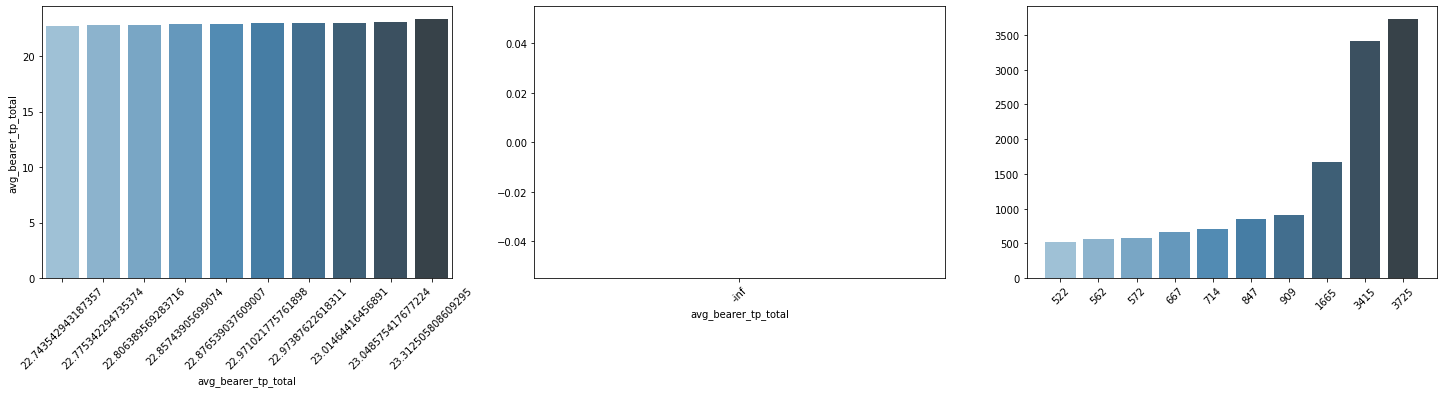

In [19]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_tcp, x=top_10_tcp.index, orient='v', y=top_10_tcp, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_tcp, x=bottom_10_tcp.index,orient='v', y=bottom_10_tcp.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_tcp, x=most_frequent_tcp.index,orient='v', y=most_frequent_tcp.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

[]

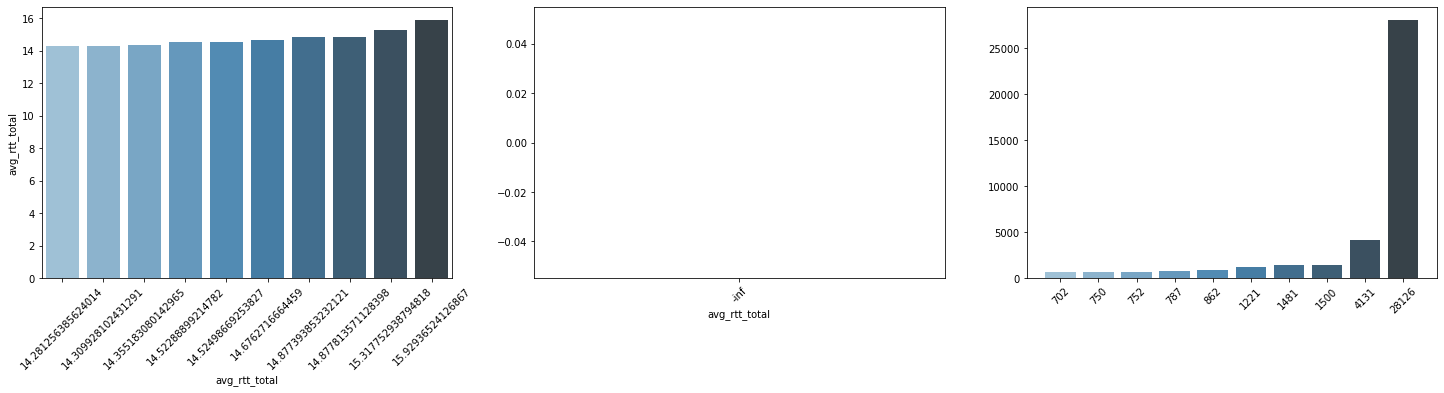

In [20]:
top_10_rtt = user_experience.nlargest(10, 'avg_rtt_total')['avg_rtt_total']
bottom_10_rtt = user_experience.nsmallest(10, 'avg_rtt_total')['avg_rtt_total']
most_frequent_rtt = user_experience.value_counts('avg_rtt_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_rtt, x=top_10_rtt.index, orient='v', y=top_10_rtt, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_rtt, x=bottom_10_rtt.index,orient='v', y=bottom_10_rtt.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_rtt, x=most_frequent_rtt.index,orient='v', y=most_frequent_rtt.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

[]

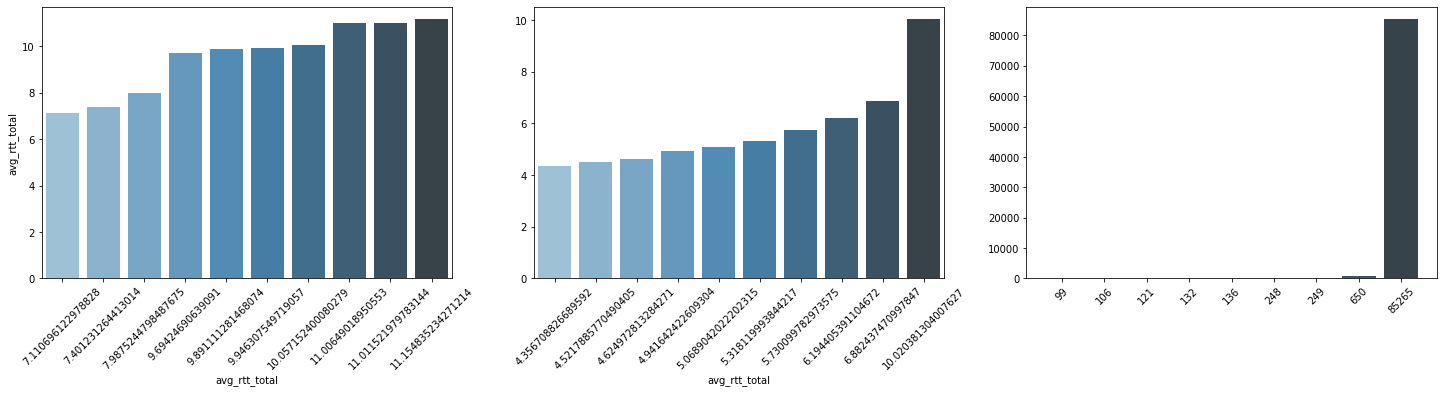

In [21]:
top_10_retrans = user_experience.nlargest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
bottom_10_retrans = user_experience.nsmallest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
most_frequent_retrans = user_experience.value_counts('avg_tcp_retrans_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_retrans, x=top_10_retrans.index, orient='v', y=top_10_retrans, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_retrans, x=bottom_10_retrans.index,orient='v', y=bottom_10_retrans.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_retrans, x=most_frequent_retrans.index,orient='v', y=most_frequent_retrans.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

In [22]:
handset_type_df = user_experience.groupby('Handset Type').agg(
    {'avg_bearer_tp_total': 'mean', 'avg_tcp_retrans_total': 'mean'})
handset_type_df.head()

,avg_bearer_tp_total,avg_tcp_retrans_total
Handset Type,,
A-Link Telecom I. Cubot A5,15.838115,23.201031
A-Link Telecom I. Cubot Note Plus,13.931197,22.845643
A-Link Telecom I. Cubot Note S,15.094590,28.653651
A-Link Telecom I. Cubot Nova,17.237061,19.012167
A-Link Telecom I. Cubot Power,16.978497,14.450689


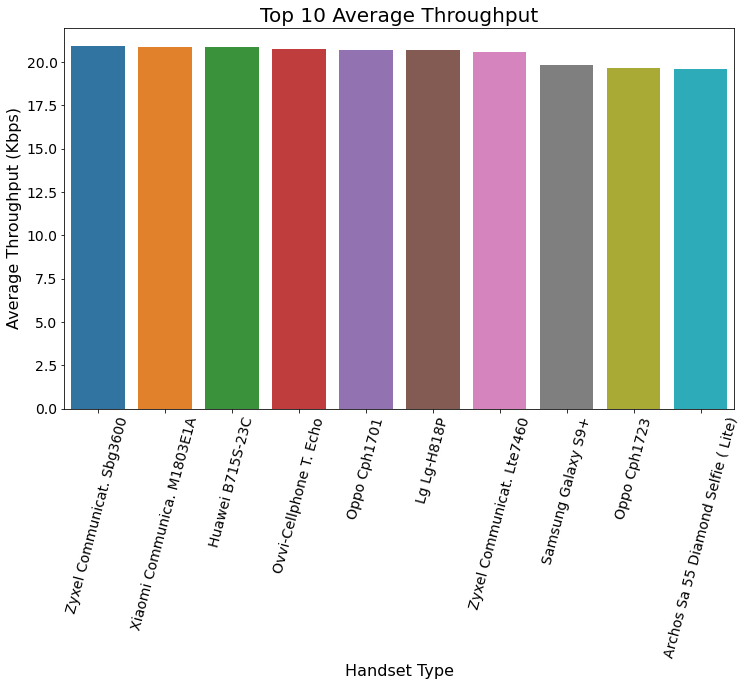

In [24]:
top_tp = handset_type_df.nlargest(10, 'avg_bearer_tp_total')
Plot().plot_bar(top_tp ,top_tp.index, top_tp.avg_bearer_tp_total, "Top 10 Average Throughput", "Handset Type", "Average Throughput (Kbps)")

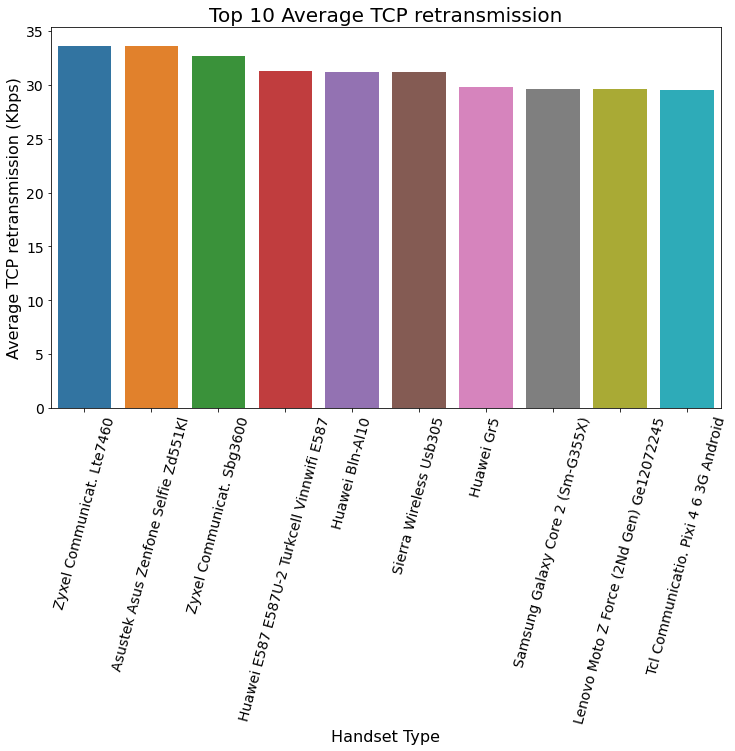

In [25]:
top_tcp = handset_type_df.nlargest(10, 'avg_tcp_retrans_total')
Plot().plot_bar(top_tcp ,top_tcp.index, top_tcp.avg_tcp_retrans_total, "Top 10 Average TCP retransmission", "Handset Type", "Average TCP retransmission (Kbps)")


In [26]:
user_experience_df.head(2)

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,Handset Type
MSISDN/Number,,,,
24.237822,-inf,7.274480,23.201031,Huawei P20 Lite Huawei Nova 3E
24.237822,3.401197,7.803027,23.201031,Apple iPhone 7 (A1778)


In [27]:
user_experience = user_experience_df.drop(['Handset Type'], axis=1)

In [28]:
user_experience.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
user_experience.isnull().sum()

avg_rtt_total          4031
avg_tp_total           1427
total_avg_tcp_total       0
dtype: int64

In [30]:
user_experience = user_experience.fillna(user_experience.mean())

In [31]:
def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data 
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [32]:
normalized_user_experience = normalizer(user_experience, ['avg_rtt_total',	'avg_tp_total',	'total_avg_tcp_total'] )

In [33]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_experience)
centroids = kmeans.cluster_centers_

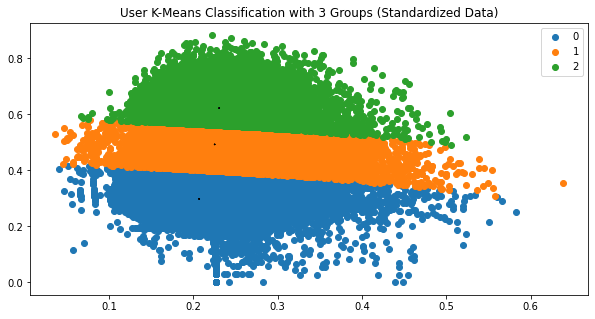

In [34]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_experience[label == i].iloc[:,0] , normalized_user_experience[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [35]:
loggers.info(f'# Centroids of the clustering:\n{centroids}')
loggers.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
loggers.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

In [36]:
u_exp = user_experience.copy()
u_exp.insert(0, 'cluster', kmeans.labels_)
u_exp.head(5)

,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
MSISDN/Number,,,,
24.237822,0,8.114390,7.274480,23.201031
24.237822,0,3.401197,7.803027,23.201031
24.237822,0,5.416100,7.763021,23.201031
24.237822,1,6.942157,9.102310,16.921539
24.237822,1,8.114390,27.135851,49.213729


In [37]:
cluster1 = u_exp[u_exp["cluster"]==0]
cluster2 = u_exp[u_exp["cluster"] == 1]
cluster3 = u_exp[u_exp["cluster"] == 2]

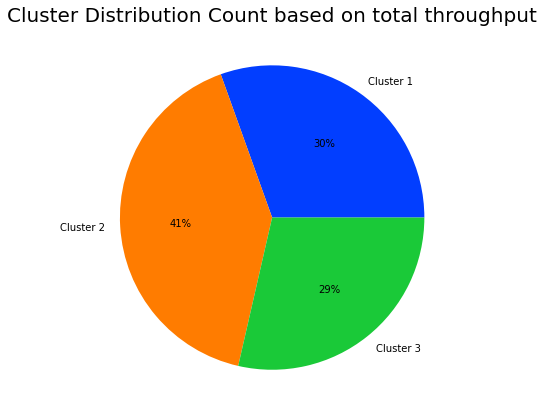

In [39]:
data = [cluster1.avg_tp_total.sum(), cluster2.avg_tp_total.sum(), cluster3.avg_tp_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
Plot().plot_pie(data, keys, "Cluster Distribution Count based on total throughput")

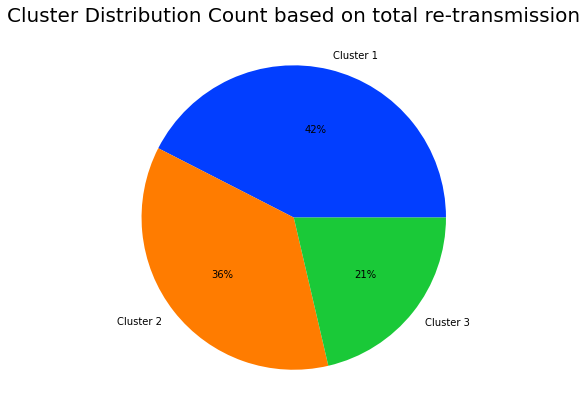

In [40]:
data = [cluster1.avg_rtt_total.sum(), cluster2.avg_rtt_total.sum(), cluster3.avg_rtt_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
Plot().plot_pie(data, keys, "Cluster Distribution Count based on total re-transmission")

In [41]:
u_exp.shape

(106856, 4)

In [42]:
u_exp.head()

,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
MSISDN/Number,,,,
24.237822,0,8.114390,7.274480,23.201031
24.237822,0,3.401197,7.803027,23.201031
24.237822,0,5.416100,7.763021,23.201031
24.237822,1,6.942157,9.102310,16.921539
24.237822,1,8.114390,27.135851,49.213729


In [43]:
with open("../models/user_exp.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [44]:
u_exp.to_csv('../data/user_exp.csv')

In [45]:
user_experience.to_csv('../data/user_experience.csv')